# Compiling HIP with OpenCV
In this notebook we will show how to compile HIP C++ code with the OpenCV library, which we will use to load an image and save it back to disk after applying a blur kernel.


## Setup

Install and load the hip4jupyter extension, which will allow us to run HIP C++ code using cell magics. See [the documentation](https://nvcc4jupyter.readthedocs.io/en/latest/usage.html) for details.

In [ ]:
!pip uninstall -y hip4jupyter
!pip install /workspaces/hip4jupyter
#%pip install hip4jupyter

Found existing installation: hip4jupyter 1.2.1
Uninstalling hip4jupyter-1.2.1:
  Would remove:
    /opt/dev-venv/lib/python3.12/site-packages/hip4jupyter-1.2.1.dist-info/*
    /opt/dev-venv/lib/python3.12/site-packages/hip4jupyter/*
Proceed (Y/n)? 

In [13]:
#%load_ext hip4jupyter
%reload_ext hip4jupyter

Source files will be saved in "/tmp/tmp09g_y34t".


Make sure OpenCV is installed.

In [5]:
%%capture
!apt update && apt install -y libopencv-dev

## Code

### Imports

In [14]:
import os
import subprocess
from pathlib import Path
from IPython.display import Image

### Download an image

Get a random image of IMG_SIZE x IMG_SIZE pixels.

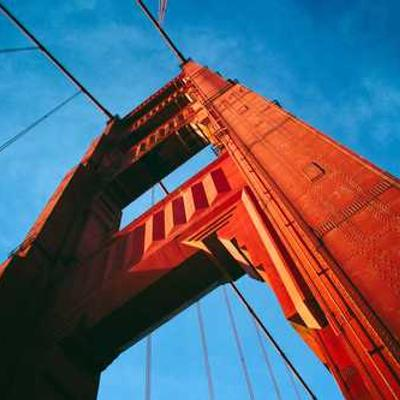

In [15]:
IMG_SIZE = 400
os.environ["IMG_SIZE"] = str(IMG_SIZE)
IMG_FNAME = "image.jpg"
os.environ["IMG_FNAME"] = IMG_FNAME

!wget -O $IMG_FNAME https://picsum.photos/$IMG_SIZE.jpg &> /dev/null
Image(filename=IMG_FNAME)

### Compiler arguments
These are options that you need to pass to the compiler in order to link with the OpenCV library.

In [16]:
# make sure the file containing the necessary compilation flags for the opencv library
# exists in a directory in the PKG_CONFIG_PATH environment variable
for path in Path('/usr/lib').rglob('opencv4.pc'):
    os.environ["PKG_CONFIG_PATH"] = os.path.dirname(str(path))
    break

# get the compilation flags required to compile our CUDA C++ code with opencv
COMPILER_ARGS = subprocess.check_output(["pkg-config", "--cflags", "--libs", "opencv4"]).decode().strip()
COMPILER_ARGS = f"-I/usr/include/opencv4 {COMPILER_ARGS}"
print(COMPILER_ARGS)

-I/usr/include/opencv4 -I/usr/include/opencv4 -lopencv_stitching -lopencv_alphamat -lopencv_aruco -lopencv_barcode -lopencv_bgsegm -lopencv_bioinspired -lopencv_ccalib -lopencv_cvv -lopencv_dnn_objdetect -lopencv_dnn_superres -lopencv_dpm -lopencv_face -lopencv_freetype -lopencv_fuzzy -lopencv_hdf -lopencv_hfs -lopencv_img_hash -lopencv_intensity_transform -lopencv_line_descriptor -lopencv_mcc -lopencv_quality -lopencv_rapid -lopencv_reg -lopencv_rgbd -lopencv_saliency -lopencv_shape -lopencv_stereo -lopencv_structured_light -lopencv_phase_unwrapping -lopencv_superres -lopencv_optflow -lopencv_surface_matching -lopencv_tracking -lopencv_highgui -lopencv_datasets -lopencv_text -lopencv_plot -lopencv_ml -lopencv_videostab -lopencv_videoio -lopencv_viz -lopencv_wechat_qrcode -lopencv_ximgproc -lopencv_video -lopencv_xobjdetect -lopencv_objdetect -lopencv_calib3d -lopencv_imgcodecs -lopencv_features2d -lopencv_dnn -lopencv_flann -lopencv_xphoto -lopencv_photo -lopencv_imgproc -lopencv_core

### Blurring the image

In [17]:
%%cuda_group_save -n "error_handling.h" -g "shared"

// error checking macro
#define cudaCheckErrors(msg) \
    do { \
        hipError_t __err = hipGetLastError(); \
        if (__err != hipSuccess) { \
            fprintf(stderr, "Fatal error: %s (%s at %s:%d)\n", \
                msg, hipGetErrorString(__err), \
                __FILE__, __LINE__); \
            fprintf(stderr, "*** FAILED - ABORTING\n"); \
            exit(1); \
        } \
    } while (0)

Saving source "/tmp/tmp09g_y34t/shared/error_handling.h"


In [18]:
%%cuda_group_save -n "blur_kernel.h" -g "shared"

#define BLUR_SIZE 5

// kernel taken from https://stackoverflow.com/a/65973288
__global__ void blurKernel(
    unsigned char* in,
    unsigned char* out,
    int width,
    int height,
    int num_channel,
    int channel
) {

    int col = blockIdx.x * blockDim.x + threadIdx.x;
    int row = blockIdx.y * blockDim.y + threadIdx.y;

    if(col < width && row < height) {
        int pixVal = 0;
        int pixels = 0;
        for(int blurRow = -BLUR_SIZE; blurRow < BLUR_SIZE + 1; ++blurRow) {
            for(int blurCol = -BLUR_SIZE; blurCol < BLUR_SIZE + 1; ++blurCol) {
                int curRow = row + blurRow;
                int curCol = col + blurCol;
                if(curRow > -1 && curRow < height && curCol > -1 && curCol < width) {
                    pixVal += in[curRow * width * num_channel + curCol * num_channel + channel];
                    pixels++;
                }
            }
        }
        out[row * width * num_channel + col * num_channel + channel] = (unsigned char)(pixVal/pixels);
    }
}

Saving source "/tmp/tmp09g_y34t/shared/blur_kernel.h"


In [19]:
%%cuda --compiler-args "$COMPILER_ARGS"

#include <iostream>

#include <opencv2/core.hpp>
#include <opencv2/imgcodecs.hpp>

#include "error_handling.h"
#include "blur_kernel.h"

#define R 0
#define G 1
#define B 2

int main()
{
    std::string image_path = cv::samples::findFile("image.jpg");
    cv::Mat img = imread(image_path, cv::IMREAD_COLOR);
    if(img.empty())
    {
        std::cerr << "Could not read the image: " << image_path << std::endl;
        return 1;
    }

    // image shape
    int width = img.cols;
    int height = img.rows;
    int n_channels = 3; // hard-coded RGB processing

    // we will read and write directly into the data array of the OpenCV Matrix
    unsigned char *host_image_input = img.data;
    unsigned char *host_image_output = img.data;

    // allocate memory for device arrays
    unsigned char* dev_image_input = NULL;
    unsigned char* dev_image_output = NULL;
    hipMalloc(
        (void**)&dev_image_input,
        sizeof(unsigned char) * height * width * n_channels
    );
    hipMalloc(
        (void**)&dev_image_output,
        sizeof(unsigned char) * height * width * n_channels
    );
    hipCheckErrors("hipMalloc failure");

    // transfer data from host to device for processing on GPU
    hipMemcpy(
        dev_image_input,
        host_image_input,
        sizeof(unsigned char) * height * width * n_channels,
        hipMemcpyHostToDevice
    );
    hipCheckErrors("cudaMemcpy H2D failure");

    // run a blur kernel on each channel
    dim3 blockSize(16, 16, 1);
    dim3 gridSize(width/blockSize.x, height/blockSize.y, 1);
    blurKernel<<<gridSize, blockSize>>>(dev_image_input, dev_image_output, width, height, n_channels, R);
    blurKernel<<<gridSize, blockSize>>>(dev_image_input, dev_image_output, width, height, n_channels, G);
    blurKernel<<<gridSize, blockSize>>>(dev_image_input, dev_image_output, width, height, n_channels, B);

    hipDeviceSynchronize();
    hipCheckErrors("kernel failure");

    // copy results back to host
    hipMemcpy(
        host_image_output,
        dev_image_output,
        sizeof(unsigned char) * height * width * n_channels,
        cudaMemcpyDeviceToHost
    );
    hipCheckErrors("cudaMemcpy D2H failure");

    hipFree(dev_image_input);
    hipFree(dev_image_output);

    // save the blurred image to disk
    cv::imwrite("image_blurred.jpg", img);
    return 0;
}

Saving source "/tmp/tmp09g_y34t/2ac514cb-a3a9-427f-9c58-ac7bd256ad2c/single_file.cu"
Group path: /tmp/tmp09g_y34t/2ac514cb-a3a9-427f-9c58-ac7bd256ad2c
['hipcc', '-I/usr/include/opencv4', '-I/usr/include/opencv4', '-lopencv_stitching', '-lopencv_alphamat', '-lopencv_aruco', '-lopencv_barcode', '-lopencv_bgsegm', '-lopencv_bioinspired', '-lopencv_ccalib', '-lopencv_cvv', '-lopencv_dnn_objdetect', '-lopencv_dnn_superres', '-lopencv_dpm', '-lopencv_face', '-lopencv_freetype', '-lopencv_fuzzy', '-lopencv_hdf', '-lopencv_hfs', '-lopencv_img_hash', '-lopencv_intensity_transform', '-lopencv_line_descriptor', '-lopencv_mcc', '-lopencv_quality', '-lopencv_rapid', '-lopencv_reg', '-lopencv_rgbd', '-lopencv_saliency', '-lopencv_shape', '-lopencv_stereo', '-lopencv_structured_light', '-lopencv_phase_unwrapping', '-lopencv_superres', '-lopencv_optflow', '-lopencv_surface_matching', '-lopencv_tracking', '-lopencv_highgui', '-lopencv_datasets', '-lopencv_text', '-lopencv_plot', '-lopencv_ml', '-lopenc

/tmp/tmp09g_y34t/2ac514cb-a3a9-427f-9c58-ac7bd256ad2c/single_file.cu:7:10: fatal error: 'error_handling.h' file not found
    7 | #include "error_handling.h"
      |          ^~~~~~~~~~~~~~~~~~
1 error generated when compiling for gfx906.
failed to execute:/opt/rocm/lib/llvm/bin/clang++  -O3 --driver-mode=g++ -O3 --hip-link  -I/usr/include/opencv4 -I/usr/include/opencv4 -lopencv_stitching -lopencv_alphamat -lopencv_aruco -lopencv_barcode -lopencv_bgsegm -lopencv_bioinspired -lopencv_ccalib -lopencv_cvv -lopencv_dnn_objdetect -lopencv_dnn_superres -lopencv_dpm -lopencv_face -lopencv_freetype -lopencv_fuzzy -lopencv_hdf -lopencv_hfs -lopencv_img_hash -lopencv_intensity_transform -lopencv_line_descriptor -lopencv_mcc -lopencv_quality -lopencv_rapid -lopencv_reg -lopencv_rgbd -lopencv_saliency -lopencv_shape -lopencv_stereo -lopencv_structured_light -lopencv_phase_unwrapping -lopencv_superres -lopencv_optflow -lopencv_surface_matching -lopencv_tracking -lopencv_highgui -lopencv_datasets -l

In [ ]:
Image(filename="image_blurred.jpg")